In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
rc("image", cmap="gray")

In [3]:
from PIL import Image, ImageFont, ImageDraw
from scipy.ndimage import measurements, filters
import scipy.ndimage as ndi
import glob, re
from itertools import islice
import os, os.path

In [4]:
fontdir = "/usr/share/fonts/truetype/"
font_list = (glob.glob(fontdir+"liberation/*.ttf") +
         glob.glob(fontdir+"freefont/*.ttf") +
         glob.glob(fontdir+"dejavu/*.ttf"))
print(len(font_list))
print(font_list[:5])
sample_font = "/usr/share/fonts/truetype/freetype/FreeMonoBold.ttf"

50
['/usr/share/fonts/truetype/liberation/LiberationSans-BoldItalic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-BoldItalic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-Italic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-BoldItalic.ttf']


In [5]:
def crop(image:np.ndarray, pad=1):
    [[r,c]] = measurements.find_objects(array(image==0,'i'))
    r0 = r.start
    r1 = r.stop
    c0 = c.start
    c1 = c.stop
    image = image[r0-pad:r1+pad,c0-pad:c1+pad]
    return image

In [6]:
def padq(image, q=16):
    h, w = image.shape
    hp = q-h%q if h%q>0 else 0
    wp = q-w%q if w%q>0 else 0
    return ndi.affine_transform(image, eye(2), output_shape=(h+hp, w+wp), mode="constant")

padq(ones((7, 7)), q=10).shape

(10, 10)

In [7]:
font_cache = {}

def load_font(fontname, size):
    pair = f"{fontname}::{size}"
    if pair not in font_cache:
        font_cache[pair] = ImageFont.truetype(fontname, size=size)
    return font_cache[pair]

In [8]:
from scipy import mgrid

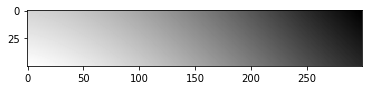

In [9]:
def mkbackground(shape, ncomponents=3, scales=(100.0, 5000.0)):
    h, w = shape
    ys, xs = mgrid[range(h), range(w)]
    result = zeros((h, w))
    for i in range(ncomponents):
        alpha = random.uniform(0, 2*pi)
        ly, lx = cos(alpha), sin(alpha)
        freq = exp(random.uniform(log(scales[0]), log(scales[1])))
        phase = random.uniform(0, 2*pi)
        amplitude = random.uniform(0, 1)
        result += sin((ly*ys+lx*xs)*2*pi/freq+phase)
    result -= amin(result)
    result /= amax(result)
    return result

imshow(mkbackground((50, 300)))

In [10]:
def normalize(a, range=(0, 1)):
    lo, hi = amin(a), amax(a)
    return (a-lo) / (hi-lo) * (range[1]-range[0]) + range[0] 

In [11]:
def mknoise(shape):
    nsigma = random.uniform(0.05, 2.0)
    noise = clip(random.normal(size=shape), -2, 2)
    noise = filters.gaussian_filter(noise, nsigma)
    return normalize(noise, range=(-1, 1))

In [12]:
def bounded_gaussian_noise(shape, sigma, maxdelta):
    n, m = shape
    deltas = pylab.rand(2, n, m)
    deltas = ndi.gaussian_filter(deltas, (0, sigma, sigma))
    deltas -= np.amin(deltas)
    deltas /= np.amax(deltas)
    deltas = (2*deltas-1) * maxdelta
    return deltas

def distort_with_noise(image, deltas, order=1):
    assert deltas.shape[0] == 2
    assert image.shape == deltas.shape[1:], (image.shape, deltas.shape)
    n, m = image.shape
    xy = np.transpose(np.array(np.meshgrid(
        range(n), range(m))), axes=[0, 2, 1])
    deltas += xy
    return ndi.map_coordinates(image, deltas, order=order, mode="constant")

def random_distort_word(image, level=1.0):
    sigma = exp(random.uniform(log(5.0), log(200.0)))
    maxdelta = level*random.uniform(0.2, 4.0)
    deltas = bounded_gaussian_noise(image.shape, sigma, maxdelta)
    return distort_with_noise(image, deltas)

(50, 161)


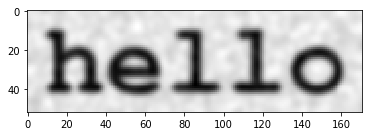

In [13]:
def gentextimage(text: str, pad:int=10, fontname=sample_font, size:int=48, maxpad=100):
    if isinstance(fontname, str): fontname = [fontname]
    if isinstance(size, int): size = [size]
    font = load_font(random.choice(fontname), random.choice(size))
    image = Image.new("L", (6000, 200))
    draw = ImageDraw.Draw(image)
    draw.rectangle((0, 0, 6000, 6000), fill="white")
    draw.text((20, 20), text, fill="black", font=font)
    image = asarray(image, "f")
    image = image / amax(image)
    image = crop(image, pad=10)
    return image

def random_padding(image, maxpad=30):
    h, w = image.shape
    p0, p1, q0, q1 = [random.randint(0, maxpad) for _ in range(4)]
    result = amax(image)*ones((h+p0+p1, w+q0+q1), dtype=image.dtype)
    result[p0:p0+h, q0:q0+w] = image
    return result

def sigmoid(x):
    return 1.0 / (1.0 + exp(-x))
def sigmoid5(x):
    return sigmoid(x-0.5)

def genline(text: str, pad:int=10, fontname=sample_font, size:int=48,
            bg=0.0,
            noiselevel=0.5,
            distort=0.0,
            maxpad=0):
    image = normalize(gentextimage(text=text, pad=pad, fontname=fontname, size=size))
    #image = sigmoid5(image + random.normal(size=image.shape)*0.3)
    sigma = random.uniform(0.05, 2.0)
    image = normalize(filters.gaussian_filter(image, sigma))
    if maxpad>0:
        image = random_padding(image, maxpad=maxpad)
    if noiselevel>0:
        noiselevel = noiselevel*random.uniform(0.05, 0.4)
        noise = mknoise(image.shape)
        image = normalize(image + noiselevel * noise)
    if bg>0:
        bg = bg * random.uniform(0.05, 0.4)
        image = normalize(image + bg * mkbackground(image.shape))
    image = 1-image
    if distort>0:
        image = normalize(random_distort_word(image))
    return image

figsize(6, 6)
imshow(1-genline("hello", size=range(48,52)))
print(genline("hello").shape)

In [14]:
from webdataset import writer
import pickle

def write_dataset(fname:str, data, n=50000):
    with open(fname, "wb") as stream:
        out = writer.TarWriter(stream)
        count = 0
        for i, (image, text) in enumerate(data):
            if count >= n: break
            if count%100==0: print(count, end=" ", file=sys.stderr, flush=True)
            out.write(dict(__key__=str(i), ppm=image, txt=text))
            count += 1
        out.close()
    print(file=sys.stderr, flush=True)
    print(f"# wrote {count} samples to {fname}")

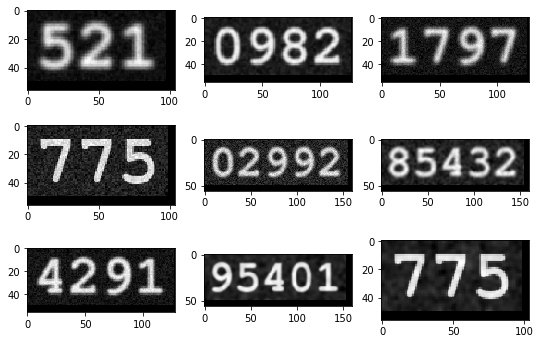

In [15]:
def gendigits(n:int=10, l0=3, l1=6, fontname=sample_font, size=48):
    result = []
    while True:
        k = random.randint(l0, l1) if l1>l0 else l0
        d = random.randint(1000000000, 1999999999)
        d = str(d)[-k:]
        image = genline(d, fontname=fontname, size=size)
        assert image.shape[0] >= 48 and image.shape[0] <= 55, image.shape
        #print(amin(image), amax(image))
        image = array(image*255.0, 'uint8')
        image = padq(image, q=8)
        yield image, d
        
figsize(9, 6)
data = list(islice(gendigits(), 0, 10))
for i in range(9):
    subplot(3, 3, i+1); imshow(data[i][0])

In [16]:
import os, os.path
if not os.path.exists("data/digits-training.tar"):
    os.system("mkdir -p data")
    write_dataset("data/digits-training.tar", gendigits(), 50000)
    write_dataset("data/digits-test.tar", gendigits(), 10000)

In [17]:
!ls /usr/share/fonts/truetype/*.ttf | grep -i mono

In [18]:
dictionary = [l.strip() for l in open("/usr/share/dict/words", "r").readlines()]
pre_specials = """'"/-"""
post_specials = """'",.?!/-"""

def choose(a):
    return a[random.randint(0, len(a)-1)]
def basic_word():
    word = choose(dictionary)
    word = re.sub(r"""[^A-Za-z]""", "", word)
    return word
def extended_word():
    result = ""
    if random.uniform()<0.05: 
        result += choose(pre_specials)
    result += choose(dictionary)
    if random.uniform()<0.1:
        result += choose(post_specials)
    elif random.uniform()<0.01:
        result += "'s"
    elif random.uniform()<0.03:
        result += "/" + choose(dictionary)
    return result

print("basic:", " ".join([basic_word() for i in range(10)]))
print("extended:", " ".join([extended_word() for i in range(10)]))

basic: nonfat Jacobites extensiveness reassured handcrafted videocassettes us Jason spits scribblers
extended: prejudicial tissue compassion's touchy, Mephistopheles spaniel's phoney's' Bailey cans unbolt


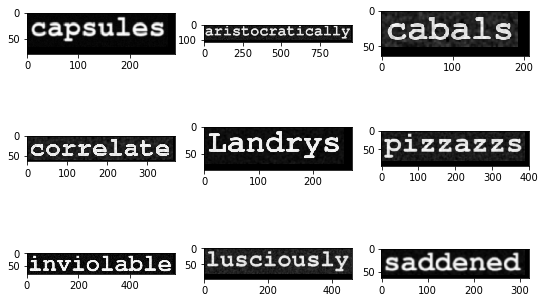

In [19]:
def genwords_simple(pad=10, extended=False, fonts=[sample_font]):
    while True:
        word = extended_word() if extended else basic_word()
        font = random.choice(fonts)
        size = random.randint(50, 100)
        image = genline(word, fontname=font, size=size)
        image = padq(image, q=16)
        yield image, word

figsize(9, 6)
data = list(islice(genwords_simple(), 0, 10))
for i in range(9):
    subplot(3, 3, i+1); imshow(data[i][0])

In [20]:
if not os.path.exists("data/words-simple-training.tar"):
    write_dataset("data/words-simple-training.tar", genwords_simple(), 50000)
    write_dataset("data/words-simple-test.tar", genwords_simple(), 10000)

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 10000 10100 10200 10300 10400 10500 10600 10700 10800 10900 11000 11100 11200 11300 11400 11500 11600 11700 11800 11900 12000 12100 12200 12300 12400 12500 12600 12700 12800 12900 13000 13100 13200 13300 13400 13500 13600 13700 13800 13900 14000 14100 14200 14300 14400 14500 14600 14700 14800 14900 15000 15100 15200 15300 15400 15500 15600 15700 15800 15900 16000 16100 16200 16300 16400 16500 16600 16700 16800 16900 17000 17100 17200 17300 17400 17500 17600 17700 17800 17900 18000 18100 18200 18300 18400 18

# wrote 50000 samples to data/words-simple-training.tar


100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 


# wrote 10000 samples to data/words-simple-test.tar


In [21]:
def genwords_hard(fonts=font_list):
    while True:
        word = extended_word()
        font = random.choice(fonts)
        size = random.randint(50, 100)
        try:
            image = genline(word, fontname=font, size=size, 
                            bg=1.0, noiselevel=1.0, distort=1.0, maxpad=30)
        except Exception as exn:
            print(exn)
            time.sleep(1.0)
            continue
        image = padq(image, q=16)
        yield image, word

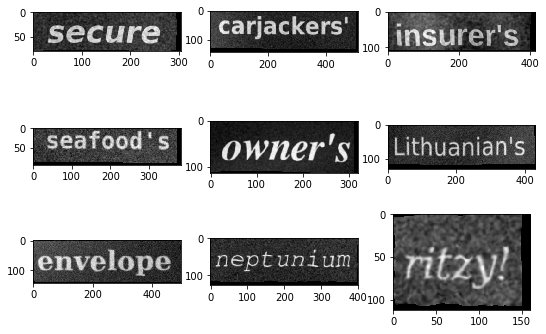

In [22]:
figsize(9, 6)
data = list(islice(genwords_hard(), 0, 10))
for i in range(9):
    subplot(3, 3, i+1); imshow(data[i][0])

In [23]:
if not os.path.exists("data/words-hard-training.tar"):
    write_dataset("data/words-hard-training.tar", genwords_hard(), 100000)
if not os.path.exists("data/words-hard-test.tar"):
    write_dataset("data/words-hard-test.tar", genwords_hard(), 10000)

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 

zero-size array to reduction operation minimum which has no identity


1400 1500 1600 1700 

zero-size array to reduction operation minimum which has no identity
zero-size array to reduction operation minimum which has no identity


1800 1900 2000 2100 2200 2300 2400 2500 2600 

zero-size array to reduction operation minimum which has no identity


2700 2800 

zero-size array to reduction operation minimum which has no identity


2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 

zero-size array to reduction operation minimum which has no identity


4300 4400 4500 4600 

zero-size array to reduction operation minimum which has no identity


4700 4800 4900 5000 5100 

zero-size array to reduction operation minimum which has no identity


5200 5300 

zero-size array to reduction operation minimum which has no identity


5400 5500 

zero-size array to reduction operation minimum which has no identity


5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 

zero-size array to reduction operation minimum which has no identity


9600 9700 9800 9900 

zero-size array to reduction operation minimum which has no identity


10000 10100 10200 10300 10400 10500 10600 10700 10800 10900 11000 11100 11200 11300 11400 11500 11600 11700 11800 11900 

zero-size array to reduction operation minimum which has no identity


12000 12100 12200 12300 12400 12500 12600 12700 12800 12900 13000 13100 

zero-size array to reduction operation minimum which has no identity


13200 13300 13400 13500 13600 13700 13800 13900 14000 14100 14200 14300 14400 14500 14600 14700 14800 

zero-size array to reduction operation minimum which has no identity


14900 15000 15100 15200 15300 15400 15500 15600 15700 15800 15900 

zero-size array to reduction operation minimum which has no identity
zero-size array to reduction operation minimum which has no identity


16000 16100 16200 16300 16400 16500 16600 16700 16800 16900 17000 17100 17200 

zero-size array to reduction operation minimum which has no identity


17300 17400 17500 

zero-size array to reduction operation minimum which has no identity


17600 

zero-size array to reduction operation minimum which has no identity


17700 17800 17900 18000 18100 18200 18300 18400 

zero-size array to reduction operation minimum which has no identity


18500 18600 18700 18800 18900 19000 19100 

zero-size array to reduction operation minimum which has no identity


19200 19300 19400 19500 19600 19700 19800 19900 20000 20100 20200 20300 20400 20500 20600 20700 20800 20900 21000 21100 21200 21300 21400 21500 21600 21700 21800 21900 22000 

zero-size array to reduction operation minimum which has no identity
zero-size array to reduction operation minimum which has no identity


22100 

zero-size array to reduction operation minimum which has no identity


22200 22300 22400 22500 22600 22700 22800 22900 23000 23100 

zero-size array to reduction operation minimum which has no identity


23200 23300 23400 23500 23600 23700 23800 23900 24000 24100 24200 24300 24400 24500 24600 24700 24800 24900 25000 25100 25200 25300 

zero-size array to reduction operation minimum which has no identity


25400 25500 25600 25700 25800 25900 26000 26100 26200 

zero-size array to reduction operation minimum which has no identity


26300 26400 26500 

zero-size array to reduction operation minimum which has no identity


26600 

zero-size array to reduction operation minimum which has no identity


26700 26800 26900 27000 27100 27200 27300 27400 27500 

zero-size array to reduction operation minimum which has no identity


27600 27700 27800 27900 28000 28100 28200 

zero-size array to reduction operation minimum which has no identity


28300 

zero-size array to reduction operation minimum which has no identity


28400 28500 28600 28700 28800 28900 29000 29100 29200 29300 29400 29500 29600 

zero-size array to reduction operation minimum which has no identity


29700 29800 29900 30000 30100 30200 30300 

zero-size array to reduction operation minimum which has no identity


30400 30500 30600 30700 30800 30900 31000 31100 31200 31300 31400 31500 31600 31700 31800 

zero-size array to reduction operation minimum which has no identity


31900 32000 32100 32200 32300 32400 32500 32600 32700 32800 32900 33000 33100 33200 33300 

zero-size array to reduction operation minimum which has no identity


33400 33500 33600 33700 33800 33900 34000 34100 34200 34300 34400 34500 34600 34700 34800 34900 35000 35100 35200 35300 35400 35500 35600 35700 35800 35900 36000 36100 36200 36300 36400 36500 36600 36700 

zero-size array to reduction operation minimum which has no identity


36800 36900 37000 37100 37200 

zero-size array to reduction operation minimum which has no identity


37300 

zero-size array to reduction operation minimum which has no identity
zero-size array to reduction operation minimum which has no identity


37400 37500 37600 37700 37800 37900 38000 38100 38200 38300 38400 38500 38600 38700 38800 38900 39000 39100 39200 39300 39400 39500 39600 39700 39800 39900 40000 40100 40200 

zero-size array to reduction operation minimum which has no identity
zero-size array to reduction operation minimum which has no identity


40300 40400 

zero-size array to reduction operation minimum which has no identity


40500 40600 40700 40800 40900 41000 41100 41200 41300 41400 41500 41600 41700 41800 41900 42000 42100 

zero-size array to reduction operation minimum which has no identity


42200 42300 42400 42500 

zero-size array to reduction operation minimum which has no identity


42600 42700 42800 42900 43000 43100 

zero-size array to reduction operation minimum which has no identity


43200 43300 43400 43500 43600 43700 43800 43900 44000 44100 44200 44300 44400 44500 44600 44700 44800 44900 45000 45100 

zero-size array to reduction operation minimum which has no identity


45200 45300 45400 45500 45600 

zero-size array to reduction operation minimum which has no identity


45700 

zero-size array to reduction operation minimum which has no identity


45800 45900 46000 46100 46200 46300 46400 46500 46600 46700 

zero-size array to reduction operation minimum which has no identity


46800 46900 47000 47100 47200 47300 47400 47500 47600 

zero-size array to reduction operation minimum which has no identity


47700 47800 47900 48000 48100 48200 48300 48400 

zero-size array to reduction operation minimum which has no identity


48500 48600 48700 48800 48900 49000 49100 49200 49300 49400 49500 49600 49700 49800 49900 50000 50100 50200 50300 50400 50500 50600 50700 50800 50900 51000 51100 51200 

zero-size array to reduction operation minimum which has no identity


51300 51400 

zero-size array to reduction operation minimum which has no identity


51500 51600 51700 

zero-size array to reduction operation minimum which has no identity


51800 51900 52000 52100 52200 52300 52400 52500 52600 52700 52800 52900 53000 53100 

zero-size array to reduction operation minimum which has no identity


53200 53300 

zero-size array to reduction operation minimum which has no identity


53400 53500 53600 53700 53800 

zero-size array to reduction operation minimum which has no identity


53900 

zero-size array to reduction operation minimum which has no identity


54000 54100 54200 54300 54400 54500 54600 54700 54800 54900 55000 55100 55200 55300 55400 55500 55600 55700 55800 55900 56000 56100 56200 

zero-size array to reduction operation minimum which has no identity


56300 56400 56500 56600 56700 56800 56900 57000 57100 57200 57300 57400 57500 57600 57700 57800 

zero-size array to reduction operation minimum which has no identity


57900 58000 58100 58200 58300 58400 58500 58600 58700 58800 58900 59000 59100 59200 59300 

zero-size array to reduction operation minimum which has no identity


59400 59500 59600 59700 59800 59900 60000 60100 60200 60300 60400 60500 60600 60700 60800 60900 61000 61100 61200 61300 61400 

zero-size array to reduction operation minimum which has no identity


61500 61600 61700 61800 61900 62000 62100 62200 62300 62400 62500 

zero-size array to reduction operation minimum which has no identity


62600 62700 62800 62900 63000 63100 63200 63300 63400 63500 

zero-size array to reduction operation minimum which has no identity


63600 63700 63800 63900 64000 64100 64200 64300 64400 64500 64600 64700 64800 64900 

zero-size array to reduction operation minimum which has no identity


65000 65100 65200 65300 65400 65500 65600 65700 65800 65900 66000 66100 66200 66300 66400 66500 66600 

zero-size array to reduction operation minimum which has no identity


66700 66800 66900 67000 

zero-size array to reduction operation minimum which has no identity


67100 67200 67300 67400 67500 67600 67700 67800 67900 68000 

zero-size array to reduction operation minimum which has no identity


68100 68200 68300 68400 68500 68600 68700 68800 68900 69000 69100 69200 69300 69400 69500 69600 69700 69800 69900 70000 70100 70200 70300 70400 70500 70600 70700 70800 70900 

zero-size array to reduction operation minimum which has no identity


71000 71100 

zero-size array to reduction operation minimum which has no identity


71200 71300 71400 

zero-size array to reduction operation minimum which has no identity


71500 71600 71700 71800 71900 72000 72100 72200 72300 72400 72500 72600 72700 72800 72900 73000 73100 73200 73300 73400 73500 73600 73700 73800 73900 

zero-size array to reduction operation minimum which has no identity


74000 74100 74200 

zero-size array to reduction operation minimum which has no identity


74300 74400 74500 74600 74700 74800 74900 75000 75100 75200 75300 75400 75500 75600 75700 75800 75900 

zero-size array to reduction operation minimum which has no identity


76000 76100 

zero-size array to reduction operation minimum which has no identity


76200 76300 76400 76500 76600 76700 76800 76900 77000 77100 

zero-size array to reduction operation minimum which has no identity


77200 77300 77400 77500 77600 77700 77800 77900 

zero-size array to reduction operation minimum which has no identity


78000 78100 78200 78300 78400 78500 

zero-size array to reduction operation minimum which has no identity


78600 78700 78800 78900 79000 79100 79200 79300 79400 79500 79600 

zero-size array to reduction operation minimum which has no identity


79700 79800 79900 80000 80100 80200 80300 80400 80500 80600 80700 80800 80900 81000 81100 

zero-size array to reduction operation minimum which has no identity


81200 81300 81400 81500 81600 

zero-size array to reduction operation minimum which has no identity
zero-size array to reduction operation minimum which has no identity


81700 81800 

zero-size array to reduction operation minimum which has no identity


81900 82000 

zero-size array to reduction operation minimum which has no identity


82100 82200 82300 82400 82500 82600 82700 82800 82900 83000 83100 83200 83300 83400 83500 83600 

zero-size array to reduction operation minimum which has no identity


83700 83800 83900 84000 84100 84200 84300 84400 84500 84600 84700 84800 84900 85000 85100 85200 85300 85400 85500 85600 85700 85800 85900 86000 86100 86200 86300 86400 86500 86600 86700 

zero-size array to reduction operation minimum which has no identity


86800 86900 87000 87100 

zero-size array to reduction operation minimum which has no identity


87200 87300 87400 87500 87600 87700 87800 87900 88000 88100 88200 88300 88400 88500 88600 88700 88800 88900 89000 

zero-size array to reduction operation minimum which has no identity


89100 89200 89300 89400 89500 89600 89700 89800 89900 90000 

zero-size array to reduction operation minimum which has no identity


90100 90200 90300 90400 90500 90600 90700 90800 90900 

zero-size array to reduction operation minimum which has no identity


91000 91100 91200 

zero-size array to reduction operation minimum which has no identity


91300 91400 91500 91600 91700 91800 91900 92000 92100 92200 

zero-size array to reduction operation minimum which has no identity


92300 92400 92500 92600 92700 92800 92900 93000 93100 93200 93300 93400 93500 93600 93700 93800 93900 

zero-size array to reduction operation minimum which has no identity


94000 94100 94200 94300 94400 

zero-size array to reduction operation minimum which has no identity


94500 

zero-size array to reduction operation minimum which has no identity


94600 94700 94800 94900 95000 95100 95200 95300 95400 95500 95600 95700 95800 95900 96000 96100 96200 96300 96400 96500 96600 96700 96800 96900 97000 97100 97200 97300 97400 97500 97600 

zero-size array to reduction operation minimum which has no identity


97700 97800 97900 98000 98100 

zero-size array to reduction operation minimum which has no identity


98200 98300 98400 98500 98600 

zero-size array to reduction operation minimum which has no identity


98700 98800 98900 99000 99100 99200 99300 99400 99500 99600 

zero-size array to reduction operation minimum which has no identity


99700 99800 99900 
0 

# wrote 100000 samples to data/words-hard-training.tar


100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 

zero-size array to reduction operation minimum which has no identity


2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 

zero-size array to reduction operation minimum which has no identity


3500 3600 3700 3800 3900 4000 4100 4200 4300 

zero-size array to reduction operation minimum which has no identity


4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 

zero-size array to reduction operation minimum which has no identity


5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 

zero-size array to reduction operation minimum which has no identity


7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 


# wrote 10000 samples to data/words-hard-test.tar
